# Save GOES-16 IR channel subregion as Geotiff
This jupyter notebook shows how to export the channel 13 of GOES-16 to GeoTiff using the GOES, pyresample and GDAL packages. This methodology can be used with other ABI channels and ABI-derived products of GOES-16 and GOES-17. This tutorial consists of the following sections:

1- Get data from netcdf <br>
2- Resample data <br>
3- Save data as geotiff <br>
4- Check the geotiff <br>

<a id='get'></a>
## 1- Get data from netcdf

Import the GOES package.

In [1]:
import GOES

Set path and name of file that will be read.

In [2]:
path = '/home/joao/Downloads/GOES-16/ABI/'
file = 'OR_ABI-L2-CMIPF-M6C13_G16_s20200782000176_e20200782009496_c20200782010003.nc'

Reads the file.

In [3]:
ds = GOES.open_dataset(path+file)

Set the map domain.

In [4]:
domain = [-90.0,-30.0,-60.0,15.0]

Gets image with the coordinates of center of their pixels.

In [5]:
CMI, LonCen, LatCen = ds.image('CMI', lonlat='center', domain=domain)

Gets information about data.

In [6]:
sat = ds.attribute('platform_ID')
band = ds.variable('band_id').data[0]
wl = ds.variable('band_wavelength').data[0]
standard_name = CMI.standard_name
units = CMI.units
time_bounds = CMI.time_bounds

<a id='resample'></a>
## 2- Resample data
Since the netcdf data has satellite projection, it is necessary to reproject it to equirectangular projection to can save it as a geotiff. The follow steps teach how to do that.

Creates a grid map with cylindrical equidistant projection and 2 km of spatial resolution.

In [7]:
LonCenCyl, LatCenCyl = GOES.create_gridmap(domain, PixResol=2.0)

Calculates the parameters for reprojection. For this we need install the **pyproj** and **pyresample** packages. Do it writing ***pip install pyproj*** and ***pip install pyresample***.

In [8]:
import pyproj as pyproj
Prj = pyproj.Proj('+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6378.137 +b=6378.137 +units=km')
AreaID = 'cyl'
AreaName = 'cyl'
ProjID = 'cyl'
Proj4Args = '+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6378.137 +b=6378.137 +units=km'

ny, nx = LonCenCyl.data.shape
SW = Prj(LonCenCyl.data.min(), LatCenCyl.data.min())
NE = Prj(LonCenCyl.data.max(), LatCenCyl.data.max())
area_extent = [SW[0], SW[1], NE[0], NE[1]]

from pyresample import utils
AreaDef = utils.get_area_def(AreaID, AreaName, ProjID, Proj4Args, nx, ny, area_extent)

Reprojects image.

In [9]:
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest
import numpy as np

SwathDef = SwathDefinition(lons=LonCen.data, lats=LatCen.data)
CMICyl = resample_nearest(SwathDef, CMI.data, AreaDef, radius_of_influence=6000,
                          fill_value=np.nan, epsilon=3, reduce_data=True)

Deletes unnecessary data.

In [10]:
del CMI, LonCen, LatCen, SwathDef

<a id='save'></a>
## 3- Save data as geotiff

To save the data as geotiff we going to creates a functions called **save_as_geotiff**. For this we need install the **gdal** packages. You can install the package with ***conda install -c conda-forge gdal***.

In [11]:
import gdal, osr

def save_as_geotiff(Field, LonsCen, LatsCen, OutputFileName):
    deltaLon = LonsCen[0,1]-LonsCen[0,0]
    deltaLat = LatsCen[1,0]-LatsCen[0,0]
    LonCor = LonsCen[-1,0] - (deltaLon)/2.0
    LatCor = LatsCen[0,0] - (deltaLat)/2.0
    #
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(OutputFileName, Field.shape[1], Field.shape[0], 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((LonCor, deltaLon, 0, LatCor, 0, deltaLat))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(Field)
    #
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

Saves data as geotiff in **/home/joao/Downloads/** with the name **data.tif**.

In [12]:
save_as_geotiff(CMICyl, LonCenCyl.data, LatCenCyl.data, '/home/joao/Downloads/data.tif')

<a id='check'></a>
## 4- Check the geotiff
Reads the geotiff.

In [13]:
gtif = gdal.Open('/home/joao/Downloads/data.tif')
geoinformation = gtif.GetGeoTransform()

nx = gtif.RasterXSize
ny = gtif.RasterYSize
xres = geoinformation[1]
yres = geoinformation[5]
ULLon = geoinformation[0]
ULLat = geoinformation[3]
bnd = gtif.GetRasterBand(1).ReadAsArray()

print('Upper left longitude: {}\nUpper left latitude: {}'.format(ULLon, ULLat))
print('Spatial resolution in X (Lon): {}\nSpatial resolution in Y (Lat): {}'.format(xres, yres))
print('Number of pixels in X: {}\nNumber of pixels in Y: {}'.format(nx, ny))

Upper left longitude: -90.0090103149414
Upper left latitude: 15.009008884429932
Spatial resolution in X (Lon): 0.0180206298828125
Spatial resolution in Y (Lat): -0.01801776885986328
Number of pixels in X: 3331
Number of pixels in Y: 4164


Calculates latitude and longitude of pixels corners.

In [14]:
LonsCor = np.arange(bnd.shape[1]+1)*xres+ULLon
LatsCor = np.arange(bnd.shape[0]+1)*yres+ULLat
LonsCor, LatsCor = np.meshgrid(LonsCor, LatsCor)

Creates the plot.

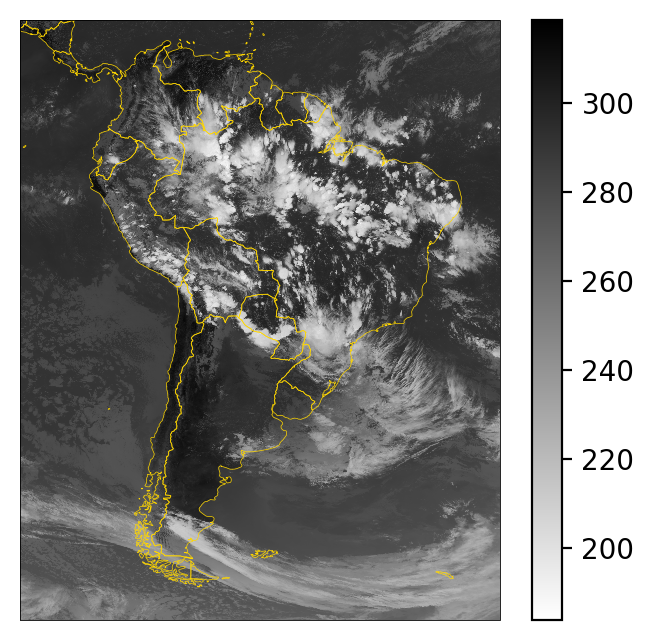

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

# calculates the central longitude of the plot
LonCenPlot = LonsCor[0,:].mean() + 360.0

# calculates the extent of the plot
ExtentPlot = [LonsCor[0,0]+360.0, LonsCor[0,-1]+360.0, LatsCor[-1,0], LatsCor[0,0]]

# creates the figure
fig = plt.figure('map', figsize=(4,4), dpi=200)
ax = fig.add_axes([0.1, 0.16, 0.80, 0.75], projection=ccrs.PlateCarree(LonCenPlot))
ax.outline_patch.set_linewidth(0.3)

# add the geographic boundaries
l = NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='50m', facecolor='none')
ax.add_feature(l, edgecolor='gold', linewidth=0.25)

# plot the data
img = ax.pcolormesh(LonsCor, LatsCor, bnd, cmap='gray_r', transform=ccrs.PlateCarree())

# add the colorbar
cb = plt.colorbar(img)

# set the map limits
ax.set_extent(ExtentPlot, crs=ccrs.PlateCarree())

plt.show()